In [1]:
%matplotlib inline

from classes.QLearningAgentClass import QLearningAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_grids, plot_trajectory
from utilities.jsonRW import writeJSON

In [2]:
#CREATING THE ENVIRONMENT
shape = "5x5"             # "5x5" or "14x14"
env = createNNEnv(shape)

Loading models...
Models loaded


In [3]:
#Hyperparameters
show_stats = True       # show stats
export_to_JSON = False  # write JSON file
render = True           # render the results after training

NUM_AGENTS = 1

if shape == "5x5":
    EPISODES_PER_AGENT = 5000
elif shape == "14x14":
    EPISODES_PER_AGENT = 15000

EPS_START = 1.0
EPS_DECAY = EPS_START/(EPISODES_PER_AGENT/2)  # reduce the exploration over time
EPS_END = 0.1

DISCOUNT_FACTOR = 0.95
LR = 0.02

In [4]:
#CREATING AND TRAINING THE AGENTS
agents_arr = []
starting_positions = []

print("Starting training of", NUM_AGENTS, "Q-learning agents")

for i in range(NUM_AGENTS):
    print("Agent", i+1, "/", NUM_AGENTS)

    agent = QLearningAgent(env, EPISODES_PER_AGENT, LR, EPS_START, EPS_DECAY, EPS_END, DISCOUNT_FACTOR)
    agent.env.unwrapped.randomize_start_pos()
    
    agent.train()
    
    agents_arr.append(agent)
    starting_positions.append(agent.env.unwrapped.start_pos)

Starting training of 1 Q-learning agents
Agent 1 / 1


  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\Blanca\anaconda3\envs\salva2\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 5000/5000 [00:19<00:00, 260.55it/s]


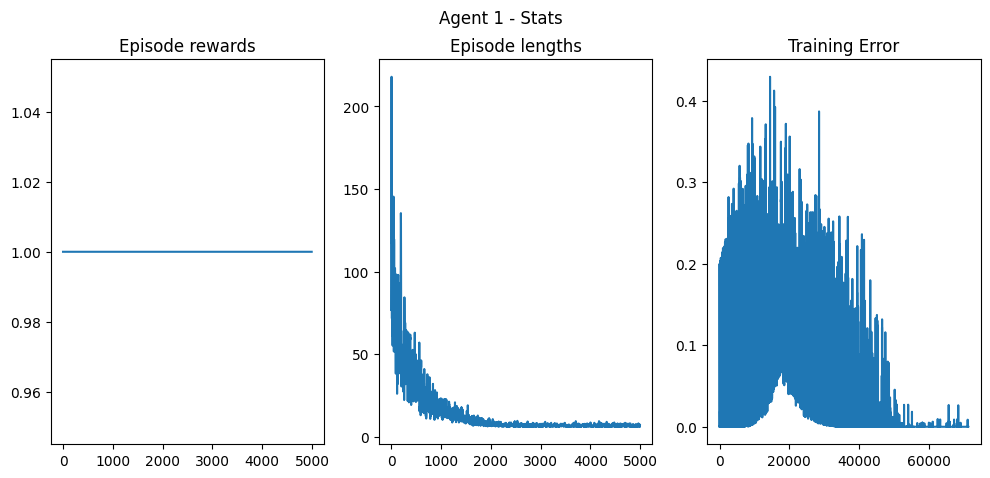

In [9]:
if show_stats:
    for i in range(len(agents_arr)):
        agents_arr[i].plot_results(i, rolling_length=5)

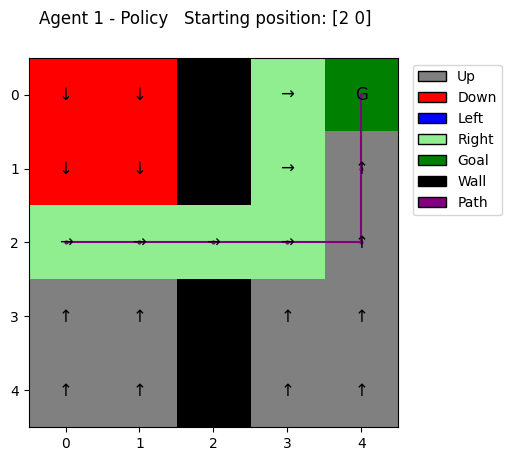

In [6]:
for i in range(len(agents_arr)):
    value_grid, policy_grid, string_policy_grid = create_grids(env, agent=agents_arr[i])

    if export_to_JSON:
        writeJSON("Q-Learning", EPISODES_PER_AGENT, 0, shape, starting_positions[i], value_grid, policy_grid, string_policy_grid)

    if render:
        plot_trajectory(string_policy_grid, starting_positions[i], i)